In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Beispiel Graph erstellen

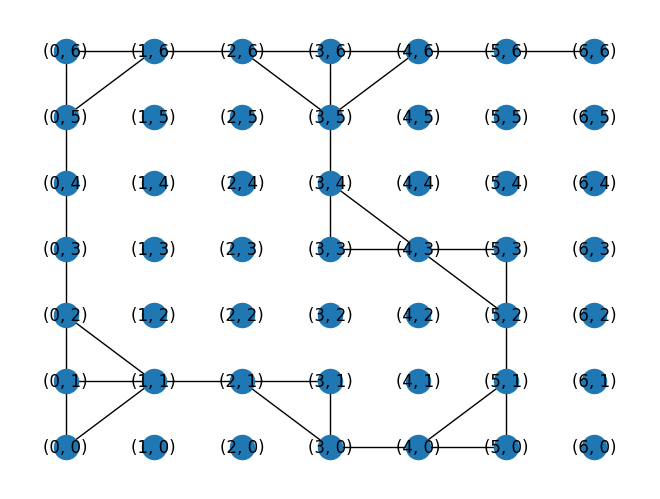

In [2]:
graph = nx.Graph()

for i in range(7):
    for j in range(6):
        graph.add_node((i,j))

graph.add_edge((0,0), (0,1), weight=1)
graph.add_edge((0,1), (0,2), weight=1)
graph.add_edge((0,2), (0,3), weight=1)
graph.add_edge((0,3), (0,4), weight=1)
graph.add_edge((0,4), (0,5), weight=1)
graph.add_edge((0,5), (0,6), weight=1)

graph.add_edge((0,6), (1,6), weight=1)
graph.add_edge((1,6), (2,6), weight=1)
graph.add_edge((2,6), (3,6), weight=1)
graph.add_edge((3,6), (4,6), weight=1)
graph.add_edge((4,6), (5,6), weight=1)
graph.add_edge((5,6), (6,6), weight=1)

graph.add_edge((0,1), (1,1), weight=1)
graph.add_edge((1,1), (2,1), weight=1)
graph.add_edge((2,1), (3,1), weight=1)
graph.add_edge((3,1), (3,0), weight=1)
graph.add_edge((3,0), (4,0), weight=1)
graph.add_edge((4,0), (5,0), weight=1)

graph.add_edge((5,0), (5,1), weight=1)
graph.add_edge((5,1), (5,2), weight=1)
graph.add_edge((5,2), (5,3), weight=1)

graph.add_edge((5,3), (4,3), weight=1)
graph.add_edge((4,3), (3,3), weight=1)
graph.add_edge((3,3), (3,4), weight=1)
graph.add_edge((3,4), (3,5), weight=1)
graph.add_edge((3,5), (3,6), weight=1)

TEST = 1.42
graph.add_edge((0,0), (1,1), weight=TEST)
graph.add_edge((2,1), (3,0), weight=TEST)
graph.add_edge((4,0), (5,1), weight=TEST)
graph.add_edge((5,2), (4,3), weight=TEST)
graph.add_edge((4,3), (3,4), weight=TEST)
graph.add_edge((3,5), (2,6), weight=TEST)
graph.add_edge((0,5), (1,6), weight=TEST)
graph.add_edge((0,2), (1,1), weight=TEST)
graph.add_edge((3,5), (4,6), weight=TEST)

# draw graph as maze
pos = {}
for node in graph.nodes():
    pos[node] = node

nx.draw(graph, pos=pos, with_labels=True)

In [3]:
class PathTracker():
    def __init__(self, graph):
        self.graph = graph
        self.parents = {}
        self.open = []
        self.incons = []
        self.closed = []

    def update(self, open_list, closed_list, incons_list):
        self.closed = []
        self.open = []
        self.incons = []
        for node in open_list:
            self.parents[node[0]] = node[1]
            self.open.append(node[0])
        for node in closed_list:
            # overrite parent if node is already in closed list
            self.parents[node[0]] = node[1]
            self.closed.append(node[0])
        for node in incons_list:
            # overrite parent if node is already in incons list
            self.parents[node[0]] = node[1]
            self.incons.append(node[0])
    
    def get_path(self, goal):
        path = [goal]
        current = goal
        while current != None:
            current = self.parents[current]
            if current != None:
                path.append(current)
        return path[::-1]
    
    def plot_path(self, goal):
        # draw graph as maze and plot path
        pos = {}
        path = self.get_path(goal)
        for node in self.graph.nodes():
            pos[node] = node
        nx.draw(self.graph, pos=pos, with_labels=True)
        nx.draw_networkx_edges(self.graph, pos=pos, edgelist=[(path[i], path[i+1]) for i in range(len(path)-1)], width=10, edge_color='r', label="Current best path")
        nx.draw_networkx_nodes(self.graph, pos=pos, nodelist=self.open, node_color='y', label="Localy inconsistent nodes")
        nx.draw_networkx_nodes(self.graph, pos=pos, nodelist=self.closed, node_color='g', label="Closed nodes")
        nx.draw_networkx_nodes(self.graph, pos=pos, nodelist=self.incons, node_color='y')
        plt.legend()
        plt.show()

In [4]:
def f(start, goal, epsilon, g, h):
    # calculate the f value for a given start and goal node
    return g[start] + epsilon * h(start, goal)

def h(start, goal):
    # calculate the euclidean distance between start and goal
    return np.sqrt((start[0] - goal[0])**2 + (start[1] - goal[1])**2)

def improve_path(graph, goal, epsilon, open_list, closed_list, incons_list, g, h):
    # improve the path until the f value of the goal node is the smallest f value in the open list
    while f(goal, goal, epsilon, g, h) > min([f(x[0], goal, epsilon, g, h) for x in open_list]):
        # get the node with the smallest f value
        current = open_list.pop(0)
        closed_list.append(current)
        current = current[0]
        # iterate over all neighbors of the current node
        for neighbor in graph.neighbors(current):
            # calculate the g value for the neighbor
            g_neighbor = g[current] + graph[current][neighbor]['weight']
            # if the g value of the neighbor is smaller than the current g value of the neighbor
            if g[neighbor] > g_neighbor:
                # update the g value of the neighbor
                g[neighbor] = g_neighbor
                # if the neighbor is not in the closed list
                if neighbor not in closed_list:
                    # add the neighbor to the open list
                    open_list.append((neighbor, current))
                else:
                    # add the neighbor to the incons list
                    incons_list.append((neighbor, current))
        # sort the open list by the f value of the nodes
        open_list.sort(key=lambda x: f(x[0], goal, epsilon, g, h))
    return open_list, closed_list, incons_list

def ara_star(graph, start, goal, h=h, f=f, epsilon=5, path_tracker=None):
    if path_tracker == None:
        path_tracker = PathTracker(graph)
    g = {node: np.inf for node in graph.nodes()} # init g with inf
    g[start] = 0
    open_list, closed_list, incons_list = [],[],[]
                    # current, parent
    open_list.append((start, None))
    open_list, closed_list, incons_list = improve_path(graph, goal, epsilon, open_list, closed_list, incons_list, g, h)
    path_tracker.update(open_list, closed_list, incons_list)
    path_tracker.plot_path(goal)
    while epsilon > 1:
        epsilon -= 1
        open_list = open_list + incons_list
        open_list.sort(key=lambda x: f(x[0], goal, epsilon, g, h))
        closed_list, incons_list = [], []
        open_list, closed_list, incons_list = improve_path(graph, goal, epsilon, open_list, closed_list, incons_list, g, h)
        path_tracker.update(open_list, closed_list, incons_list)
        path_tracker.plot_path(goal)


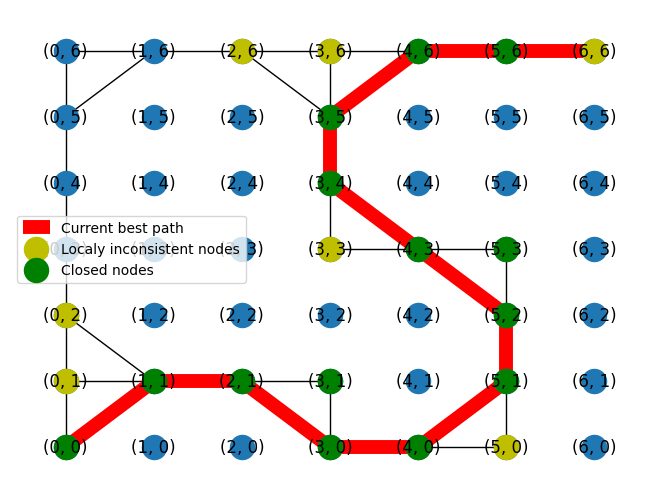

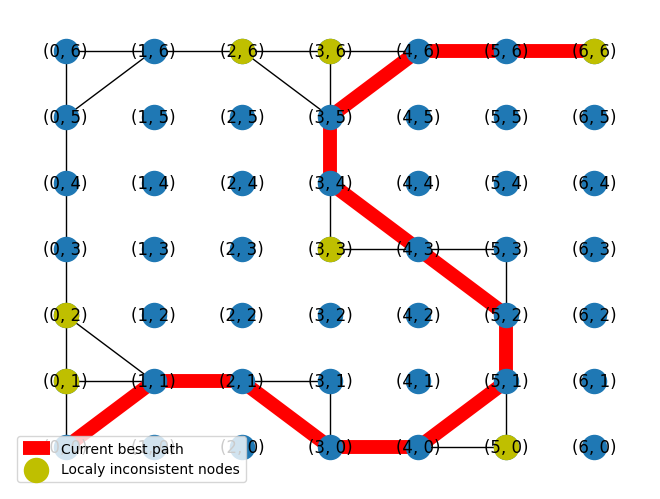

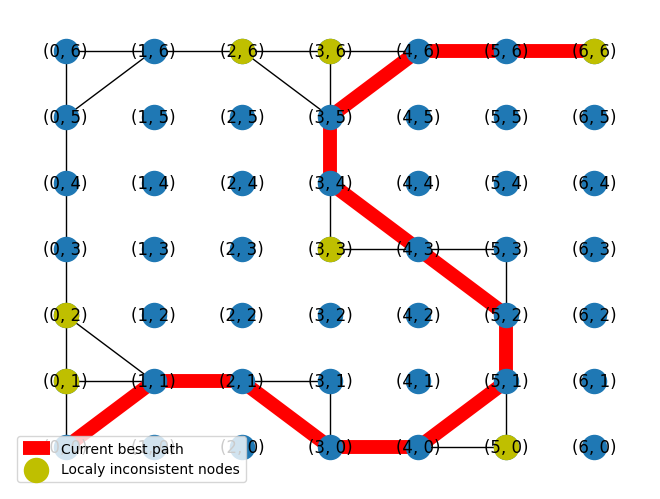

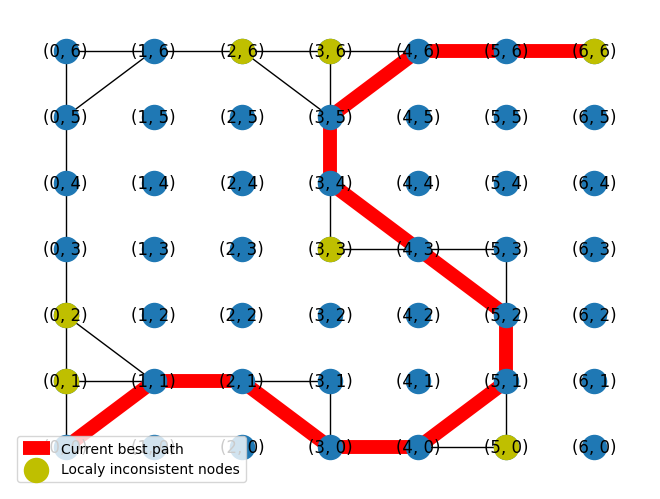

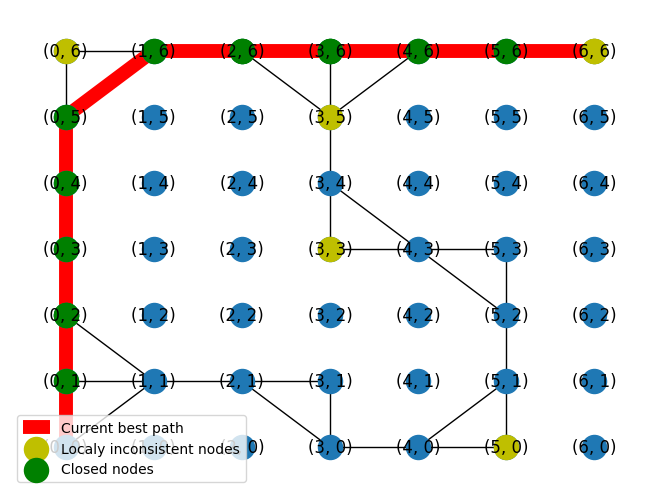

In [5]:
ara_star(graph, (0,0), (6,6))